In [22]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [23]:
import pandas as pd
from classifier.single_label_classifier import SingleLabelClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score
from preprocessing.features import BASELINE_FEATURE_COLUMNS
from preprocessing.preprocessor import Preprocessor
from preprocessing.tags import Tags
from evaluation.utils import create_confusion_matrix, create_classification_report, create_precision_recall_graph, create_receiver_operation_characteristic_graph, create_error_matrix_graph, create_feature_importance_graph, false_positives, false_negatives, create_revision_link_html, create_revisions_by_tag_graph

## Preprocess dataset

In [24]:
features = '../data/features-total-80c4772.csv'
tag_df = pd.read_csv('../data/tag.csv')
all_tags = [
    Tags.BLANKING,
    Tags.NONSENSE,
    Tags.QUALITY_ISSUE,
    Tags.PERSONAL_STORY,
    Tags.FALSE_FACT,
    Tags.SYNTAX,
    Tags.MERGE_CONFLICT,
    Tags.TEMPLATE,
    Tags.EDIT_WARS,
    Tags.SEO,
    Tags.INTENTION
]

preprocessor = Preprocessor(features, all_tags, BASELINE_FEATURE_COLUMNS, vandalism_sample_rate=0.3)
output = preprocessor.run()
clf = SingleLabelClassifier(output, 300)

## Evaluate classifier on undersampled trainings set

In [25]:
clf.cross_validate()

{'fit_time': array([3.64127588, 3.62735105, 4.03268313, 3.97930217, 3.86072898,
        3.86639118, 4.46466494, 4.49384403, 2.53789687, 2.49199891]),
 'score_time': array([1.05528593, 1.04957485, 1.05738187, 1.03010678, 1.06398797,
        1.05205369, 1.03347611, 1.059057  , 1.02069116, 1.03783393]),
 'test_f1': array([0.58031088, 0.6039604 , 0.65024631, 0.625     , 0.68686869,
        0.71497585, 0.625     , 0.67317073, 0.63589744, 0.62686567]),
 'test_precision': array([0.68292683, 0.67032967, 0.7173913 , 0.74074074, 0.7816092 ,
        0.77083333, 0.74074074, 0.72631579, 0.72941176, 0.69230769]),
 'test_recall': array([0.5045045 , 0.54954955, 0.59459459, 0.54054054, 0.61261261,
        0.66666667, 0.54054054, 0.62727273, 0.56363636, 0.57272727]),
 'test_roc_auc': array([0.81722843, 0.8340464 , 0.86055167, 0.87451987, 0.85145611,
        0.89723444, 0.86425379, 0.87771318, 0.86242072, 0.84245948]),
 'test_accuracy': array([0.78108108, 0.78378378, 0.80810811, 0.80487805, 0.83197832,
 

In [26]:
y_train_predict, y_train_predict_proba = clf.train_predict()
y_train = output.y_train

In [27]:
# Evaluate model parameters: Confusion matrix
create_confusion_matrix(y_train, y_train_predict)

,Predicted No Vandalism,Predicted Vandalism
True No Vandalism,2341,242
True Vandalism,468,639


In [28]:
# Evaluate model parameters: Classification report
print(create_classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

No Vandalism       0.83      0.91      0.87      2583
   Vandalism       0.73      0.58      0.64      1107

 avg / total       0.80      0.81      0.80      3690



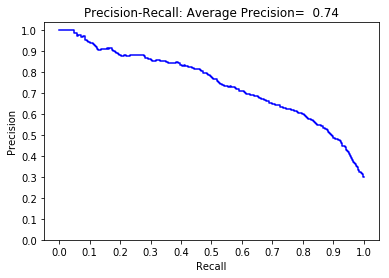

PR-AUC 0.7432515218366091


In [29]:
plt, pr_auc = create_precision_recall_graph(y_train, y_train_predict_proba[:,1])
plt.show()
print("PR-AUC", pr_auc)

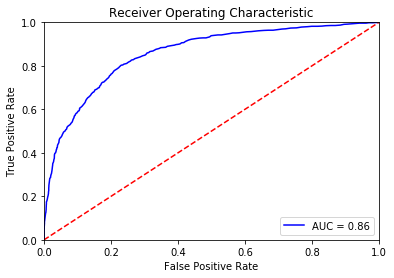

ROC-AUC 0.8580225930017721


In [30]:
plt, roc_auc = create_receiver_operation_characteristic_graph(y_train, y_train_predict_proba[:,1])
plt.show()
print("ROC-AUC", roc_auc)

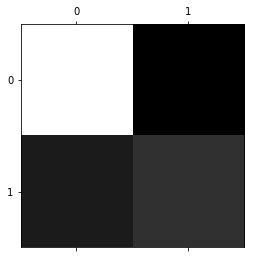

In [31]:
plt = create_error_matrix_graph(y_train, y_train_predict)
plt.show()

## Evaluate classifier on non-undersampled test set

In [32]:
y_predict, y_predict_proba = clf.test_predict()
y = output.y_test

In [33]:
# Evaluate model parameters: Confusion matrix
create_confusion_matrix(y, y_predict)

,Predicted No Vandalism,Predicted Vandalism
True No Vandalism,787,80
True Vandalism,160,215


In [34]:
# Evaluate model parameters: Classification report
print(create_classification_report(y, y_predict))

              precision    recall  f1-score   support

No Vandalism       0.83      0.91      0.87       867
   Vandalism       0.73      0.57      0.64       375

 avg / total       0.80      0.81      0.80      1242



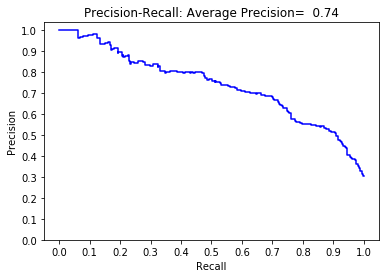

PR-AUC 0.7379747895940157


In [35]:
plt, pr_auc = create_precision_recall_graph(y, y_predict_proba[:,1])
plt.show()
print("PR-AUC", pr_auc)

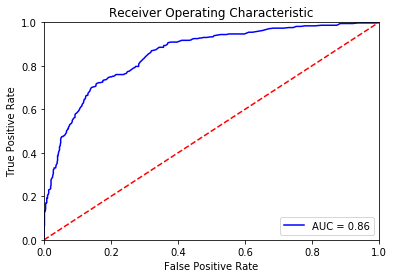

ROC-AUC 0.8552633602460592


In [36]:
plt, roc_auc = create_receiver_operation_characteristic_graph(y, y_predict_proba[:,1])
plt.show()
print("ROC-AUC", roc_auc)

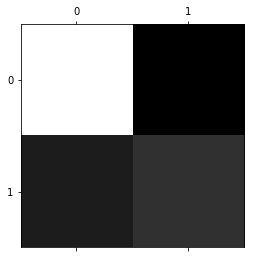

In [37]:
plt = create_error_matrix_graph(y, y_predict)
plt.show()

In [38]:
# False positives
fp = false_positives(output.X_test_with_meta, y, y_predict)
create_revision_link_html(fp, tag_df, 10)

HTML(value='<ul><li>constructive: <a href="http://en.wikipedia.org/index.php?diff=305725624">305725624 </a></l…

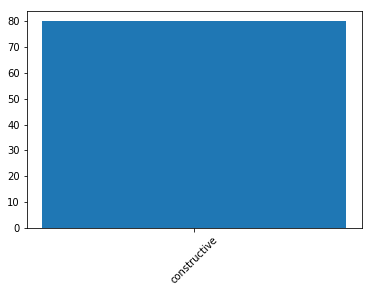

In [39]:
plt = create_revisions_by_tag_graph(fp, tag_df)
plt.show()

In [40]:
# False negatives
fn = false_negatives(output.X_test_with_meta, y, y_predict)
create_revision_link_html(fn, tag_df, 10)

HTML(value='<ul><li>FalseFacts: <a href="http://en.wikipedia.org/index.php?diff=751988902">751988902 </a></li>…

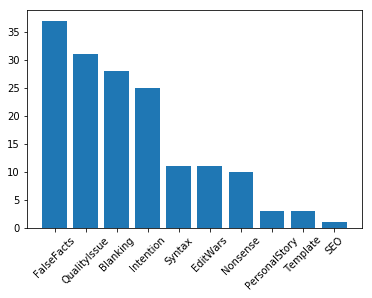

In [41]:
plt = create_revisions_by_tag_graph(fn, tag_df)
plt.show()

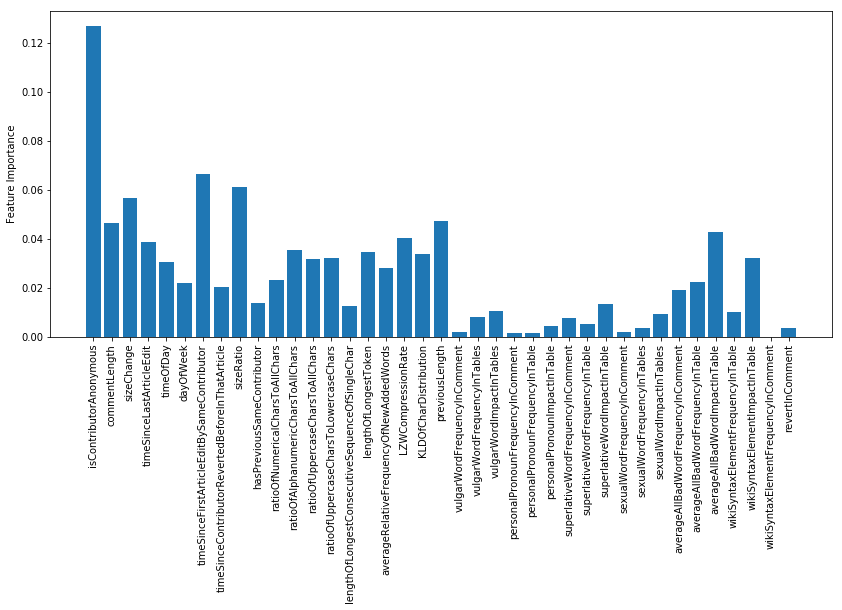

In [42]:
plt = create_feature_importance_graph(clf, output.labels)
plt.show()